## Import Modules

In [ ]:
import numpy as np
from astropy.io import fits
import os
import tensorflow as tf
from tensorflow.keras import layers, models, activations, callbacks
import matplotlib.pyplot as plt
import pandas as pd
import keras
from tensorflow.keras.models import save_model

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.layers import Input, Conv2D, Dropout, Concatenate, MaxPooling2D, Conv2DTranspose, UpSampling2D, BatchNormalization, Add, Multiply
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
from keras import Model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy import ndimage
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib as mpl




## Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Define Functions

In [ ]:
# Normalises the image
def preprocess_image(filepath):
    hdul = fits.open(filepath)
    data = hdul[0].data
    normalised_data = data/np.max(data)
    return normalised_data


def preprocess_mask(filepath):
    # Read .fits file
    hdul = fits.open(filepath)
    data = hdul[0].data
    return data


# Loads images from directory in alphabetical order
def load_images(directory):
  data = []
  files_in_directory = sorted(os.listdir(directory))
  for file_name in files_in_directory:
      file_path = os.path.join(directory, file_name)
      data.append(preprocess_image(file_path))
  return np.array(data)


# Loads masks from directory in alphabetical order
def load_mask(directory):
  data = []
  files_in_directory = sorted(os.listdir(directory))
  for file_name in files_in_directory:
      file_path = os.path.join(directory, file_name)
      data.append(preprocess_mask(file_path))

  return np.array(data)

# Function for displaying images, masks and predictions
def display(display_list):
  fig, axs = plt.subplots(1, 3, figsize=(10,10),  sharex=True, layout='constrained')
  title = ['Input Image', 'True Mask', 'Predicted Mask']


  axs[0].set_title(title[0])
  axs[0].imshow(display_list[0], 'gray')
  axs[0].axis('off')

  axs[1].set_title(title[1])
  axs[1].imshow(display_list[1], 'viridis')
  axs[1].axis('off')

  axs[2].set_title(title[2])
  norm = Normalize(vmin=0, vmax=1)
  ax2 = axs[2].imshow(display_list[2], 'viridis', norm=norm)
  axs[2].axis('off')

  fig.colorbar(ax2, ax=axs[2], shrink=0.3)

  plt.show()

## Data

In [ ]:
# Load imagess and masks
dir_masks = '/content/drive/MyDrive/Project Colab Notebooks/subhalo_from_each_bin/mask'
dir_images = '/content/drive/MyDrive/Project Colab Notebooks/subhalo_from_each_bin/image'
masks= load_mask(dir_masks)
images= load_images(dir_images)



In [ ]:
# Slice datasets into training, validation and testing datasets
mask_train= masks[:8000]
mask_validation=masks[8000:9000]
mask_test=masks[-1000:]

images_train= images[:8000]
images_validation=images[8000:9000]
images_test=images[-1000:]

# Define arrays for storing the accuracies, precisions, recalls, TPs, FPs, and FNs from each image
# Needs to be defined higher up where the arrays wont be overwritten when running more times for no attention
# vs attention. The code later presumes that no attention U-Net will be run first before the attention U-Net
accs = np.array([])
precs = np.array([])
recs = np.array([])

true_pos = np.array([])
false_pos = np.array([])
false_neg = np.array([])

## Binary Classification U-Net

In [ ]:

input = Input((80, 80, 1))

#encoder
c1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(input)
c1 = BatchNormalization()(c1)
c1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2,2), strides = 2, padding = 'same')(c1)


c2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(p1)
c2 = BatchNormalization()(c2)
c2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2,2), strides = 2, padding = 'same')(c2)


c3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(p2)
c3 = BatchNormalization()(c3)
c3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2,2), strides = 2, padding = 'same')(c3)

#bottel neck
c4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(p3)
c4 = BatchNormalization()(c4)
c4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(c4)
c4 = BatchNormalization()(c4)

#decoder

t6 = Conv2DTranspose(2**8, (2,2), strides = 2, padding = 'valid', activation = 'relu')(c4)
conc6 = Concatenate()([t6, c3])
c6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conc6)
c6 = BatchNormalization()(c6)
c6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(c6)
c6 = BatchNormalization()(c6)

t7 = Conv2DTranspose(2**7, (2,2), strides = 2, padding = 'valid', activation = 'relu')(c6)
conc7 = Concatenate()([t7, c2])
c7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conc7)
c7 = BatchNormalization()(c7)
c7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(c7)
c7 = BatchNormalization()(c7)

t8 = Conv2DTranspose(2**6, (2,2), strides = 2, padding = 'valid', activation = 'relu')(c7)
conc8 = Concatenate()([t8, c1])
c8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conc8)
c8 = BatchNormalization()(c8)
c8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(c8)
c8 = BatchNormalization()(c8)

#output
outly = Conv2D(1, (1,1), activation = 'sigmoid', padding = 'same')(conv8)

model = Model(inputs = inply, outputs = outly, name = 'U-net')

model.compile(loss = keras.losses.BinaryCrossentropy(),
              optimizer = keras.optimizers.Adam(),
              metrics = ['accuracy'])

## Multi-Class U-Net

In [ ]:
channels = np.shape(mask_train)[3]

input = Input((80, 80, 1))

#encoder
c1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(input)
c1 = BatchNormalization()(c1)
c1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2,2), strides = 2, padding = 'same')(c1)


c2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(p1)
c2 = BatchNormalization()(c2)
c2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2,2), strides = 2, padding = 'same')(c2)


c3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(p2)
c3 = BatchNormalization()(c3)
c3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2,2), strides = 2, padding = 'same')(c3)

#bottel neck
c4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(p3)
c4 = BatchNormalization()(c4)
c4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(c4)
c4 = BatchNormalization()(c4)

#decoder

t6 = Conv2DTranspose(2**8, (2,2), strides = 2, padding = 'valid', activation = 'relu')(c4)
conc6 = Concatenate()([t6, c3])
c6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conc6)
c6 = BatchNormalization()(c6)
c6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(c6)
c6 = BatchNormalization()(c6)

t7 = Conv2DTranspose(2**7, (2,2), strides = 2, padding = 'valid', activation = 'relu')(c6)
conc7 = Concatenate()([t7, c2])
c7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conc7)
c7 = BatchNormalization()(c7)
c7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(c7)
c7 = BatchNormalization()(c7)

t8 = Conv2DTranspose(2**6, (2,2), strides = 2, padding = 'valid', activation = 'relu')(c7)
conc8 = Concatenate()([t8, c1])
c8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conc8)
c8 = BatchNormalization()(c8)
c8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(c8)
c8 = BatchNormalization()(c8)

#output
output = Conv2D(channels, (1,1), activation = 'softmax', padding = 'same')(c8)

model = Model(inputs = input, outputs = output, name = 'U-net')
model.compile(loss = keras.losses.BinaryCrossentropy(),
              optimizer = keras.optimizers.Adam(),
              metrics = ['accuracy'])

In [ ]:
# Summarise the model parameters, layers, etc.
model.summary()

## Unet with attention

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.layers import Input, Conv2D, Dropout, Concatenate, MaxPooling2D, Conv2DTranspose, UpSampling2D, BatchNormalization, Add, Multiply
import tensorflow.keras.backend as K

from tensorflow.keras.utils import plot_model

In [ ]:
def Attention(x, g, inter_shape):

    shape_x = K.int_shape(x)
    shape_g = K.int_shape(g)

    # Getting the gating signal to the same number of filters as the inter_shape
    phi_g = Conv2D(filters=inter_shape,
                   kernel_size=1,
                   strides=1,
                   padding='same')(g)

    # Getting the x signal to the same shape as the gating signal
    theta_x = Conv2D(filters=inter_shape,
                     kernel_size=3,
                     strides=(shape_x[1] // shape_g[1],
                              shape_x[2] // shape_g[2]),
                     padding='same')(x)

    # Element-wise addition of the gating and x signals
    add_xg = Add()([phi_g, theta_x])
    add_xg = activations.relu(add_xg)

    # 1x1x1 convolution
    psi = Conv2D(filters=1, kernel_size=1, padding='same')(add_xg)
    psi = activations.sigmoid(psi)
    shape_sigmoid = K.int_shape(psi)

    # Upsampling psi back to the original dimensions of x signal
    upsample_sigmoid_xg1 = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1],
                                             shape_x[2] //
                                             shape_sigmoid[2]))(psi)

    # Expanding the filter axis to the number of filters in the original x signal
    upsample_sigmoid_xg = K.repeat_elements(upsample_sigmoid_xg1, shape_x[3], axis=3)


    # Element-wise multiplication of attention coefficients back onto original x signal
    attn_coefficients = Multiply()([upsample_sigmoid_xg, x])

    # Final 1x1x1 convolution to consolidate attention signal to original x dimensions
    output = Conv2D(filters=shape_x[3],
                    kernel_size=1,
                    strides=1,
                    padding='same')(attn_coefficients)
    output = BatchNormalization()(output)
    return output, upsample_sigmoid_xg1

channels = np.shape(mask_train)[3]

inply = Input((80, 80, 1,))

#encoder
conv1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(inply)
conv1 = BatchNormalization()(conv1)
conv1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conv1)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv1)


conv2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conv2)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv2)


conv3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conv3)
conv3 = BatchNormalization()(conv3)
pool3 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv3)

#bottle neck
convm = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(pool3)
convm = BatchNormalization()(convm)
convm = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(convm)
convm = BatchNormalization()(convm)

#decoder
attn1, heatmap1 = Attention(conv3, convm, 2**9)
tran6 = Conv2DTranspose(2**8, (2,2), strides = 2, padding = 'valid', activation = 'relu')(convm)
conc6 = Concatenate()([tran6, conv3])
conv6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conc6)
conv6 = BatchNormalization()(conv6)
conv6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conv6)
conv6 = BatchNormalization()(conv6)
conc6 = Concatenate(axis=3)([conv6, attn1])

attn2, heatmap2 = Attention(conv2, conc6, 2**8)
tran7 = Conv2DTranspose(2**7, (2,2), strides = 2, padding = 'valid', activation = 'relu')(conv6)
conc7 = Concatenate()([tran7, conv2])
conv7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conc7)
conv7 = BatchNormalization()(conv7)
conv7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conv7)
conv7 = BatchNormalization()(conv7)
conv7 = Concatenate(axis=3)([conv7, attn2])

attn3, heatmap3 = Attention(conv1, conv7, 2**7)
tran8 = Conv2DTranspose(2**6, (2,2), strides = 2, padding = 'valid', activation = 'relu')(conv7)
conc8 = Concatenate()([tran8, conv1])
conv8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conc8)
conv8 = BatchNormalization()(conv8)
conv8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conv8)
conv8 = BatchNormalization()(conv8)
conv8 = Concatenate(axis=3)([conv8, attn3])

#output
outly = Conv2D(channels, (1,1), activation = 'softmax', padding = 'same')(conv8)


model = keras.Model(inputs = inply, outputs = outly, name = 'U-net')

model.compile(loss = keras.losses.BinaryCrossentropy(),
              optimizer = keras.optimizers.Adam(),
              metrics = ['accuracy'])

In [ ]:
plot_model(model)

## Train Model

In [ ]:
batch_size = 32
num_epochs = 50

# Define early stopping and learning rate scheduler
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=0.000001)
stopping = callbacks.EarlyStopping(monitor='val_loss', patience=15)

# Delete previous history variable as it can impact the next training paradigm
del history
history = model.fit(images_train, mask_train,
                    epochs = num_epochs,
                    batch_size = batch_size,
                    validation_data = (images_validation, mask_validation),
                    callbacks=[reduce_lr,stopping])

## Validation

In [ ]:
# Calculate validation accuracy
test_loss, test_acc = model.evaluate(images_test, mask_test,  verbose=2)
print('\nTest accuracy:', test_acc)

NameError: name 'image_test' is not defined

In [ ]:
# Loss vs epochs graph
mpl.rcParams["font.family"] = ["DejaVu Serif"]
mpl.rcParams["font.size"] = 30
mpl.rcParams["lines.linewidth"] = 3

loss = history.history['loss']
val_loss  = history.history['val_loss']

fig, ax = plt.subplots(figsize=(20,15))
ax.plot(range(0,len(loss)), loss[0:], label= 'Training Loss')
ax.plot(range(0,len(loss)), val_loss[0:], label= 'Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_xlim(0,37)
ax.legend(loc="center right")
plt.show()

In [ ]:
# Accuracy vs epochs graph

val_accuracy  = history.history['val_accuracy']
train_accuracy = history.history['accuracy']

fig, ax = plt.subplots(figsize=(20,15))
ax.plot(range(0,len(loss)), train_accuracy[0:], label= 'Training Accuracy')
ax.plot(range(0,len(loss)), val_accuracy[0:], label= 'Validation accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_xlim(0,37)
ax.legend(loc="center right")
plt.show()

## Save model

In [ ]:
model.save('/content/drive/MyDrive/Project Colab Notebooks/SavedModel SubhaloEachBin/NoAttn.h5')


## Load in saved model

In [ ]:
saved_model_path = '/content/drive/MyDrive/SavedModel SubhaloEachBin/Attn.h5'
model = tf.keras.models.load_model(saved_model_path)

## Predictions for Multiple Channels

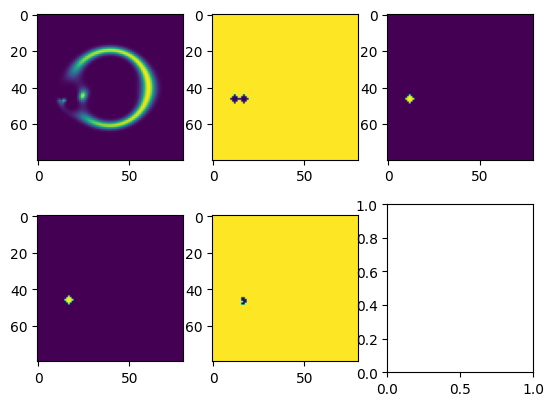

In [ ]:
# Show an example output
pred_mask = model.predict(images_test)
classes = np.argmax(pred_mask, axis=-1)
i=987
fig, ax = plt.subplots(2,3)

ax[0,0].imshow(image_test[i])
ax[0,1].imshow(mask_test[i, :, :, 2])
ax[0,2].imshow(mask_test[i, :, :, 0])
ax[1,0].imshow(mask_test[i, :, :, 1])
ax[1,1].imshow(classes[i])

In [ ]:
# Display the grount truth masks for a given image
colors = ['black', 'red', 'purple']
custom_cmap = ListedColormap(colors)
bounds = [0, 1, 2,3]
norm = BoundaryNorm(bounds, custom_cmap.N)
fig, ax = plt.subplots(1, 3, figsize=(10,10),  sharex=True, layout='constrained')
ax[0].imshow(image)
ax[1].imshow(masks[:,:,0], cmap=custom_cmap, norm=norm)
ax2 = ax[2].imshow(masks[:,:,1],cmap=custom_cmap, norm=norm)
colorbar = fig.colorbar(ax2, ax=ax[2], shrink=0.25,ticks=[0.5, 1.5, 2.5], orientation='vertical')  # Set ticks in the middle of each segment
colorbar.set_ticklabels(['Bckg', '$10^{8.75}$-$10^{9.25}M_{\odot}$', '$10^{9.75}$-$10^{10.25}M_{\odot}$'])  # Set tick labels


# Creating Nice Figures for the Report

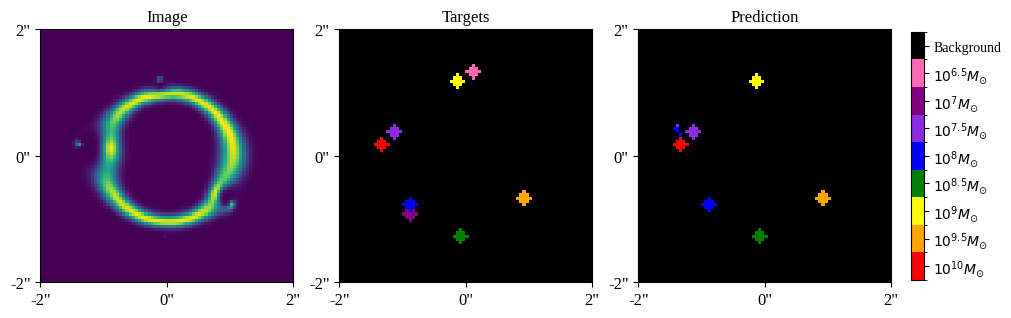

In [ ]:
# Figure showing image, true mask, and predictions
# The true mask and prediction will be the argmax accross all channels

# Choose a prediction to display
i = 1
pred=model.predict(image)

# Argmax over all channels for both the prediction and ground truth
prediction = np.argmax(pred[i], axis=-1)
true_mask  = np.argmax(masks[i], axis=-1)

# Choose the colours for the colour bar
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'blueviolet', 'purple', 'hotpink', 'black']
colourmap = ListedColormap(colors)
bounds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
norm = BoundaryNorm(bounds, colourmap.N)
plt.rcParams['font.family'] = 'Liberation Serif'

# Plot the images
fig, ax = plt.subplots(1, 3, figsize=(10,10),  sharex=True, layout='constrained')
ax[0].imshow(images[i],extent=(-2, 2, -2, 2))
ax[0].set_xticks([-2,0,2])
ax[0].set_yticks([-2,0,2])
ax[0].set_xticklabels(['{}"'.format(tick) for tick in np.arange(-2, 3, 2)], fontsize=12)
ax[0].set_yticklabels(['{}"'.format(tick) for tick in np.arange(-2, 3, 2)], fontsize=12)
ax[0].set_title('Image', fontsize=12)

ax[1].imshow(true_mask, cmap=colourmap, norm=norm, extent=(-2, 2, -2, 2))
ax[1].set_xticks([-2,0,2])
ax[1].set_yticks([-2,0,2])
ax[1].set_xticklabels(['{}"'.format(tick) for tick in np.arange(-2, 3, 2)], fontsize=12)
ax[1].set_yticklabels(['{}"'.format(tick) for tick in np.arange(-2, 3, 2)], fontsize=12)
ax[1].set_title('Targets', fontsize=12)

ax2 = ax[2].imshow(prediction,cmap=colourmap, norm=norm, extent=(-2, 2, -2, 2)) #show argmax of predictions#
ax[2].set_xticks([-2,0,2])
ax[2].set_yticks([-2,0,2])
ax[2].set_xticklabels(['{}"'.format(tick) for tick in np.arange(-2, 3, 2)], fontsize=12)
ax[2].set_yticklabels(['{}"'.format(tick) for tick in np.arange(-2, 3, 2)], fontsize=12)
ax[2].set_title('Prediction', fontsize=12)

colorbar = fig.colorbar(ax2, ax=ax[2], shrink=0.25,ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5], orientation='vertical') #make colourbar#
colorbar.set_ticklabels([ '$10^{10}M_{\odot}$', '$10^{9.5}M_{\odot}$','$10^{9}M_{\odot}$',
                         '$10^{8.5}M_{\odot}$', '$10^{8}M_{\odot}$', '$10^{7.5}M_{\odot}$', '$10^{7}M_{\odot}$'
                         ,'$10^{6.5}M_{\odot}$','Background'])  #Set colourbar labels#


#will work better when all the classes are present#

In [ ]:
# Code for showing individual channels of the prediction
fig, ax = plt.subplots(3, 3, figsize=(10,10),  sharex=True, layout='constrained') #make figure#
plt.rcParams['font.family'] = 'Liberation Serif'
probabilities = pred[i]

ax[0,0].imshow(probabilities[:,:,0],'coolwarm',extent=(-2, 2, -2, 2)) #image in default viridis colour map
ax[0,0].set_xticks([-2,0,2])
ax[0,0].set_yticks([-2,0,2])
ax[0,0].set_xticklabels(['{}"'.format(tick) for tick in np.arange(-2, 3, 2)], fontsize=12)
ax[0,0].set_yticklabels(['{}"'.format(tick) for tick in np.arange(-2, 3, 2)], fontsize=12)
ax[0,0].set_title('$10^{10}M_{\odot}$', fontsize=12)

ax[0,1].imshow(probabilities[:,:,1] ,'coolwarm' ,extent=(-2, 2, -2, 2)) #image in default viridis colour map
ax[0,1].set_xticks([-2,0,2])
ax[0,1].set_yticks([-2,0,2])
ax[0,1].set_xticklabels(['{}"'.format(tick) for tick in np.arange(-2, 3, 2)], fontsize=12)
ax[0,1].set_yticklabels(['{}"'.format(tick) for tick in np.arange(-2, 3, 2)], fontsize=12)
ax[0,1].set_title('$10^{9.5}M_{\odot}$', fontsize=12)

ax[0,2].imshow(probabilities[:,:,2] ,'coolwarm' ,extent=(-2, 2, -2, 2)) #image in default viridis colour map
ax[0,2].set_xticks([-2,0,2])
ax[0,2].set_yticks([-2,0,2])
ax[0,2].set_xticklabels(['{}"'.format(tick) for tick in np.arange(-2, 3, 2)], fontsize=12)
ax[0,2].set_yticklabels(['{}"'.format(tick) for tick in np.arange(-2, 3, 2)], fontsize=12)
ax[0,2].set_title('$10^{9}M_{\odot}$', fontsize=12)

ax[1,0].imshow(probabilities[:,:,3],'coolwarm',extent=(-2, 2, -2, 2)) #image in default viridis colour map
ax[1,0].set_xticks([-2,0,2])
ax[1,0].set_yticks([-2,0,2])
ax[1,0].set_xticklabels(['{}"'.format(tick) for tick in np.arange(-2, 3, 2)], fontsize=12)
ax[1,0].set_yticklabels(['{}"'.format(tick) for tick in np.arange(-2, 3, 2)], fontsize=12)
ax[1,0].set_title('$10^{8.5}M_{\odot}$', fontsize=12)

ax[1,1].imshow(probabilities[:,:,4] ,'coolwarm' ,extent=(-2, 2, -2, 2)) #image in default viridis colour map
ax[1,1].set_xticks([-2,0,2])
ax[1,1].set_yticks([-2,0,2])
ax[1,1].set_xticklabels(['{}"'.format(tick) for tick in np.arange(-2, 3, 2)], fontsize=12)
ax[1,1].set_yticklabels(['{}"'.format(tick) for tick in np.arange(-2, 3, 2)], fontsize=12)
ax[1,1].set_title('$10^{8}M_{\odot}$', fontsize=12)

ax[1,2].imshow(probabilities[:,:,5] ,'coolwarm' ,extent=(-2, 2, -2, 2)) #image in default viridis colour map
ax[1,2].set_xticks([-2,0,2])
ax[1,2].set_yticks([-2,0,2])
ax[1,2].set_xticklabels(['{}"'.format(tick) for tick in np.arange(-2, 3, 2)], fontsize=12)
ax[1,2].set_yticklabels(['{}"'.format(tick) for tick in np.arange(-2, 3, 2)], fontsize=12)
ax[1,2].set_title('$10^{7.5}M_{\odot}$', fontsize=12)

ax[2,0].imshow(probabilities[:,:,6],'coolwarm',extent=(-2, 2, -2, 2)) #image in default viridis colour map
ax[2,0].set_xticks([-2,0,2])
ax[2,0].set_yticks([-2,0,2])
ax[2,0].set_xticklabels(['{}"'.format(tick) for tick in np.arange(-2, 3, 2)], fontsize=12)
ax[2,0].set_yticklabels(['{}"'.format(tick) for tick in np.arange(-2, 3, 2)], fontsize=12)
ax[2,0].set_title('$10^{7}M_{\odot}$', fontsize=12)

ax[2,1].imshow(probabilities[:,:,7] ,'coolwarm' ,extent=(-2, 2, -2, 2)) #image in default viridis colour map
ax[2,1].set_xticks([-2,0,2])
ax[2,1].set_yticks([-2,0,2])
ax[2,1].set_xticklabels(['{}"'.format(tick) for tick in np.arange(-2, 3, 2)], fontsize=12)
ax[2,1].set_yticklabels(['{}"'.format(tick) for tick in np.arange(-2, 3, 2)], fontsize=12)
ax[2,1].set_title('$10^{6.5}M_{\odot}$', fontsize=12)

ax[2,2].imshow(probabilities[:,:,8] ,'coolwarm' ,extent=(-2, 2, -2, 2)) #image in default viridis colour map
ax[2,2].set_xticks([-2,0,2])
ax[2,2].set_yticks([-2,0,2])
ax[2,2].set_xticklabels(['{}"'.format(tick) for tick in np.arange(-2, 3, 2)], fontsize=12)
ax[2,2].set_yticklabels(['{}"'.format(tick) for tick in np.arange(-2, 3, 2)], fontsize=12)
ax[2,2].set_title('Background', fontsize=12)

ax2 = ax[2,2].imshow(probabilities[:,:,0], 'coolwarm' ,extent=(-2, 2, -2, 2))


colorbar = fig.colorbar(ax2, ax=ax[2,2], shrink=0.8, ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
colorbar.set_ticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

# Counting Subhalos

In [ ]:
# Function for calculating the number of TP, FP, and FNs
def generate_matrix(actual, predicted, class_name):
    TP, FP, FN, TN = 0, 0, 0, 0
    # Variables to store the number of TP, FP, and FNs per mass bin
    # "one" corresponds to the highest mass bin and decreases accordingly
    one,two,three,four,five,six,seven,eight = 0,0,0,0,0,0,0,0
    oneFN,twoFN,threeFN,fourFN,fiveFN,sixFN,sevenFN,eightFN = 0,0,0,0,0,0,0,0
    oneFP,twoFP,threeFP,fourFP,fiveFP,sixFP,sevenFP,eightFP = 0,0,0,0,0,0,0,0

    # Variable for showing "prints" number of predictions
    prints = -1

    # Loop through the number of images in the test dataset
    for k in range(len(predicted)):
        # If it is the background mask, skip it
        if k%9==8:
          continue

        # Have a running FN and FP counter as the algorithm scans the prediction top to bottom
        # which could lead to erroneous FNs and FPs specifically
        running_FN = 0
        running_FP = 0

        # Define variable for tracking whether a TP has already been found
        duplicate = 0

        # Loop through the number of pixel groups identified in the prediction mask
        for j in range(1, int(predicted[k])+1):
            # Variable for tracking the number of correct pixels
            num_corr = 0

            # Find the pixel coordinates of where the pixel group in the prediction mask
            # and the ground truth mask
            pred_true = np.argwhere(labels[:,:,k]==j)
            ground_true = np.argwhere(mask_tests[...,k]==1)

            # Loop through each predicted pixel
            for element in pred_true:
                # Loop through each ground truth pixel
                for l in range(np.shape(ground_true)[0]):
                    if np.array_equal(np.array(element),np.array(ground_true[l][:2])):
                        num_corr += 1

            # If there is a prediction where there shouldnt be at all, FP
            if np.shape(pred_true)[0] > 0 and np.shape(ground_true)[0] == 0:
                FP += 1
                continue

            # If there is no prediction and there shouldnt be, FN
            elif np.shape(pred_true)[0] == 0 and np.shape(ground_true)[0] == 0:
                TN += 1
                continue

            # If there is no prediction but there should be, FN
            elif np.shape(pred_true)[0] == 0 and np.shape(ground_true)[0] != 0:
                FN += 1
                if k%9==0:
                  oneFN += 1
                elif k%9==1:
                  twoFN += 1
                elif k%9==2:
                  threeFN += 1
                elif k%9==3:
                  fourFN += 1
                elif k%9==4:
                  fiveFN += 1
                elif k%9==5:
                  sixFN += 1
                elif k%9==6:
                  sevenFN += 1
                elif k%9==7:
                  eightFN += 1
                continue

            # If there is enough overlap between the prediction pixel group and the ground
            # truth, TP
            if num_corr/np.shape(pred_true)[0]>=0.3 and duplicate==0:
                TP += 1
                # Set duplicate to 1 so extra TPs are not identified
                duplicate += 1
                if k%9==0:
                  one += 1
                elif k%9==1:
                  two += 1
                elif k%9==2:
                  three += 1
                elif k%9==3:
                  four += 1
                elif k%9==4:
                  five += 1
                elif k%9==5:
                  six += 1
                elif k%9==6:
                  seven += 1
                elif k%9==7:
                  eight += 1
                continue

            # If there is enough overlap but a TP has been found, ignore this mask
            elif num_corr/np.shape(pred_true)[0]>=0.3 and duplicate!=0:
                continue

            # If there is not enough overlap and the TP hasnt been found yet, increase the
            # running totals
            elif num_corr/np.shape(pred_true)[0]<0.3 and duplicate==0:
                running_FN += 1
                running_FP += 1
                '''
                if prints >= 0:
                    fig, axs = plt.subplots(1,5, figsize = (20,10))

                    axs[0].axis("off")
                    axs[1].axis("off")
                    axs[2].axis("off")
                    axs[3].axis("off")
                    axs[4].axis("off")

                    axs[0].set_title("(a)")
                    axs[1].set_title("(b)")
                    axs[2].set_title("(c)")
                    axs[3].set_title("(d)")
                    axs[4].set_title("(e)")

                    axs[0].imshow(images_test[k,...])
                    axs[1].imshow(mask_test[k,...][...,0])
                    axs[2].imshow(pred_masks1[:,:,k])
                    axs[3].imshow(rounds[:,:,k])
                    axs[4].imshow((np.reshape(labels[:,:,k], (80,80)) + mask_test[k][...,0]))
                    prints -= 1
                    '''
            # If there is not enough overlap but the TP has already been found, FP
            elif num_corr/np.shape(pred_true)[0]<0.3 and duplicate!=0:
                FP += 1
                if k%9==0:
                  oneFP += 1
                elif k%9==1:
                  twoFP += 1
                elif k%9==2:
                  threeFP += 1
                elif k%9==3:
                  fourFP += 1
                elif k%9==4:
                  fiveFP += 1
                elif k%9==5:
                  sixFP += 1
                elif k%9==6:
                  sevenFP += 1
                elif k%9==7:
                  eightFP += 1

        # If at the end of the loop a TP wasn't found, increase FP and FN by the running total
        if duplicate == 0:
            FN += 1
            FP += running_FP
            if k%9==0:
              oneFN += 1
              oneFP += running_FP
            elif k%9==1:
              twoFN += 1
              twoFP += running_FP
            elif k%9==2:
              threeFN += 1
              threeFP += running_FP
            elif k%9==3:
              fourFN += 1
              fourFP += running_FP
            elif k%9==4:
              fiveFN += 1
              fiveFP += running_FP
            elif k%9==5:
              sixFN += 1
              sixFP += running_FP
            elif k%9==6:
              sevenFN += 1
              sevenFP += running_FP
            elif k%9==7:
              eightFN += 1
              eightFP += running_FP


    # Calculate overall accuracy, precision and recall of the test dataset
    acc = (TP+TN)/(TP+TN+FP+FN)

    try:
      prec = (TP)/(TP+FP)
    except:
      prec = None
      print("Can't calculate precision")

    try:
      recall = (TP)/(TP+FN)
    except:
      recall = None
      print("Can't calculate recall")

    return np.array([[TN, FP],[FN, TP]]), acc, prec, recall,one,two,three,four,five,six,seven,eight,oneFP,twoFP,threeFP,fourFP,fiveFP,sixFP,sevenFP,eightFP,oneFN,twoFN,threeFN,fourFN,fiveFN,sixFN,sevenFN,eightFN

In [ ]:
# Array for holding the number of predicted pixel groups
predicted = np.array([])
# Number of subhalos in the ground truth masks
actual = np.ones(1000)
# Array for storing the images of the labelled predictions
labels = np.zeros((80,80,9*len(actual)))
# Array for storing the images of the predictions
pred_masks = np.zeros((80,80,9*len(actual)))
# Array for storing the rounded predictions
rounds = np.zeros((80,80,9*len(actual)))
# Array for storing the ground truth masks
mask_tests = np.zeros((80,80,9*len(actual)))

# Define the structuring element for the connected component analysis
struct_elem = ndimage.generate_binary_structure(4, 4)

idx = 0
# Loop through the images in the test dataset
for i in range(len(actual)):
  image = np.reshape(images_test[i], (1,80,80,1))
  pred_mask = model.predict(image, verbose=None)
  pred_mask = np.reshape(pred_mask, (80,80,9))
  # Loop through each channel and append the relevant arrays individually
  for ch in range(9):
    pred_mask1 = pred_mask[...,ch]
    rounded = pred_mask1 >= 0.5
    rounded = np.reshape(rounded, (1,80,80,1))
    label, num_subs = ndimage.label(rounded, struct_elem)
    labels[:,:,idx] = np.reshape(label[...,0], (80,80))
    pred_masks[:,:,idx] = pred_mask1
    rounds[:,:,idx] = np.reshape(rounded[...,0], (80,80))
    mask_tests[:,:,idx] = mask_test[i,...,ch]
    predicted = np.append(predicted, num_subs)
    idx += 1

# Call the counting function
conf_mat, acc, prec, recall,one,two,three,four,five,six,seven,eight,oneFP,twoFP,threeFP,fourFP,fiveFP,sixFP,sevenFP,eightFP,oneFN,twoFN,threeFN,fourFN,fiveFN,sixFN,sevenFN,eightFN =  generate_matrix(num_subs,
                                                            predicted,

                                                            'A')

# Plot the confusion matrix
displ = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
displ.plot()

print(f"Accuracy: {acc}")

try:
  print(f"Precision: {prec}")
except:
  print("Precision: N/A")

try:
  print(f"Recall: {recall}")
except:
  print("Recall: N/A")

# Store the accuracy, precision and recall for each mass bin
oneacc = one/(one+oneFP+oneFN)
oneprec = one/(one+oneFP)
onerec = one/(one+oneFN)

twoacc = two/(two+twoFP+twoFN)
twoprec = two/(two+twoFP)
tworec = two/(two+twoFN)

threeacc = three/(three+threeFP+threeFN)
threeprec = three/(three+threeFP)
threerec = three/(three+threeFN)

fouracc = four/(four+fourFP+fourFN)
fourprec = four/(four+fourFP)
fourrec = four/(four+fourFN)

fiveacc = five/(five+fiveFP+fiveFN)
fiveprec = five/(five+fiveFP)
fiverec = five/(five+fiveFN)

sixacc = six/(six+sixFP+sixFN)
sixprec = six/(six+sixFP)
sixrec = six/(six+sixFN)

sevenacc = seven/(seven+sevenFP+sevenFN)
sevenprec = seven/(seven+sevenFP)
sevenrec = seven/(seven+sevenFN)

eightacc = eight/(eight+eightFP+eightFN)
eightprec = eight/(eight+eightFP)
eightrec = eight/(eight+eightFN)

accs = np.append(accs, [oneacc, twoacc, threeacc, fouracc, fiveacc, sixacc, sevenacc, eightacc])
precs = np.append(precs, [oneprec, twoprec, threeprec, fourprec, fiveprec, sixprec, sevenprec, eightprec])
recs = np.append(recs, [onerec, tworec, threerec, fourrec, fiverec, sixrec, sevenrec, eightrec])

true_pos = np.append(true_pos, [one, two, three, four, five, six, seven, eight])
false_pos = np.append(false_pos, [oneFP, twoFP, threeFP, fourFP, fiveFP, sixFP, sevenFP, eightFP])
false_neg = np.append(false_neg, [oneFN, twoFN, threeFN, fourFN, fiveFN, sixFN, sevenFN, eightFN])


0 897 1887 6113
Accuracy: 0.6870855344498146
Precision: 0.872039942938659
Recall: 0.764125


In [ ]:
masses = np.arange(10,6,-0.5)
mpl.rcParams["font.size"] = 30

# Assumes the no attention U-Net was run before attention
TP_noattn = true_pos[:8]
FP_noattn = false_pos[:8]
FN_noattn = [:8]
TP_attn = true_pos[8:]
FP_attn = false_pos[8:]
FN_attn = false_neg[8:]

x = np.arange(len(masses))*2  # the label locations
width = 0.75  # the width of the bars

# Plot the numbers of TP, FN, and FP by mass bin
fig, ax = plt.subplots(figsize=(20,15))
attn_bars = ax.bar(x-width/2, TP_attn, width=width, label='Attention')
noattn_bars = ax.bar([i + width/2 for i in x], TP_noattn, width=width, label='No Attention')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('True Positives')
ax.set_xlabel("Mass Bin ($10^{x}M_{\odot}$)")
ax.set_ylim(0,1000)
ax.set_xticks(ticks=x, labels=[str(int(i)) if int(i)==i else str(i) for i in np.arange(10,6,-0.5)])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

fig, ax = plt.subplots(figsize=(20,15))
attn_bars = ax.bar(x-width/2, FN_attn, width=width, label='Attention')
noattn_bars = ax.bar([i + width/2 for i in x], FN_noattn, width=width, label='No Attention')
ax.set_ylabel('False Negatives')
ax.set_xlabel("Mass Bin ($10^{x}M_{\odot}$)")
ax.set_ylim(0,1000)
ax.set_xticks(ticks=x, labels=[str(int(i)) if int(i)==i else str(i) for i in np.arange(10,6,-0.5)])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

fig, ax = plt.subplots(figsize=(20,15))
attn_bars = ax.bar(x-width/2, FP_attn, width=width, label='Attention')
noattn_bars = ax.bar([i + width/2 for i in x], FP_noattn, width=width, label='No Attention')
ax.set_ylabel('False Positives')
ax.set_xlabel("Mass Bin ($10^{x}M_{\odot}$)")
ax.set_ylim(0,1000)
ax.set_xticks(ticks=x, labels=[str(int(i)) if int(i)==i else str(i) for i in np.arange(10,6,-0.5)])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


# Plot the accuracy, precision and recall per mass bin
fig = plt.figure(figsize=(30,20))
ax = plt.subplot(111)
ax.plot(masses, accs[56:]*100, color=(0,0,1), linestyle="solid", label='Attention')
ax.plot(masses, accs[16:24]*100, color=(1,0,0), linestyle="solid", label='No Attention')
ax.set_xlabel("Mass Bin ($10^{x}M_{\odot}$)")
ax.set_ylabel("Accuracy (%)")
ax.set_xticks(ticks=masses,labels=[f"{i:g}" for i in masses])
ax.set_xlim((masses[0],masses[-1]))
ax.set_yticks(ticks=np.arange(0,110,10), labels=[str(i) for i in range(0,110,10)])
ax.set_ylim((0,100))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig = plt.figure(figsize=(30,20))
ax = plt.subplot(111)
ax.plot(masses, precs[56:]*100, color=(0,0,1), linestyle="solid", label='Attention')
ax.plot(masses, precs[16:24]*100, color=(1,0,0), linestyle="solid", label='No Attention')
ax.set_xlabel("Mass Bin ($10^{x}M_{\odot}$)")
ax.set_ylabel("Precision (%)")
ax.set_xticks(ticks=masses,labels=[f"{i:g}" for i in masses])
ax.set_xlim((masses[0],masses[-1]))
ax.set_yticks(ticks=np.arange(0,110,10), labels=[str(i) for i in range(0,110,10)])
ax.set_ylim((0,100))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig = plt.figure(figsize=(30,20))
ax = plt.subplot(111)
ax.plot(masses, recs[56:]*100, color=(0,0,1), linestyle="solid", label='Attention')
ax.plot(masses, recs[:8]*100, color=(1,0,0), linestyle="solid", label='No Attention')
ax.set_xlabel("Mass Bin ($10^{x}M_{\odot}$)")
ax.set_ylabel("Recall (%)")
ax.set_xticks(ticks=masses,labels=[f"{i:g}" for i in masses])
ax.set_xlim((masses[0],masses[-1]))
ax.set_yticks(ticks=np.arange(0,110,10), labels=[str(i) for i in range(0,110,10)])
ax.set_ylim((0,100))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


# Attention Heatmaps

In [ ]:
def show_predictions(images, masks, num=5, i=0):
    # Plot "num" examples
    for i in range(num-1,num):
        image = np.reshape(images[i], (1,80,80,1))
        mask = masks[i]
        pred_mask = model.predict(image, verbose=None)

        # Make the true mask
        b = np.zeros((80,80))
        for j in range(8):
          a = np.where(mask[:,:,j]==1)
          b[a[0], a[1]] += (j+1)

        # Argmax over all classes to get an image of all the predictions
        prediction = np.argmax(pred_mask, axis=-1)
        colors = ['black','hotpink', 'purple', 'blueviolet', 'blue', 'green', 'yellow', 'orange','red']
        colourmap = ListedColormap(colors)
        bounds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        norm = BoundaryNorm(bounds, colourmap.N)

        # Predict the images with the output being the attention weights of the last attention gate
        grad_model = tf.keras.models.Model(
              inputs=inply, # img inputs
              outputs=[heatmap3])
        heatmap = grad_model.predict(image, verbose=None)

        # Plot the images
        fig, axs = plt.subplots(1,5, figsize = (20,10), gridspec_kw={'width_ratios': [0.18, 0.23, 0.18, 0.23, 0.18]})
        axs[0].axis("off")
        axs[1].axis("off")
        axs[2].axis("off")
        axs[3].axis("off")
        axs[4].axis("off")

        axs[0].set_title("(a)")
        axs[1].set_title("(b)")
        axs[2].set_title("(c)")
        axs[3].set_title("(d)")
        axs[4].set_title("(e)")

        axs[0].imshow(np.squeeze(image), cmap="gray", aspect="equal")
        ax1 = axs[1].imshow(b, cmap=colourmap, norm=norm)
        colorbar = fig.colorbar(ax1, ax=axs[1], shrink=0.32,ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5], orientation='vertical') #make colourbar#
        colorbar.set_ticklabels(['Bckgrd', '$10^{6.5}M_{\odot}$', '$10^{7}M_{\odot}$','$10^{7.5}M_{\odot}$',
                                '$10^{8}M_{\odot}$', '$10^{8.5}M_{\odot}$', '$10^{9}M_{\odot}$', '$10^{9.5}M_{\odot}$'
                                ,'$10^{10}M_{\odot}$'])  #Set colourbar labels#
        axs[2].imshow(prediction[0],cmap=colourmap, norm=norm)
        attn_map1 = axs[3].imshow(heatmap[0,:,:,0], cmap="bwr")
        plt.colorbar(attn_map1, ax=axs[3], shrink=0.32)
        axs[4].imshow(np.squeeze(image), cmap="bwr")
        axs[4].imshow(b, cmap=colourmap, norm=norm, alpha=0.6)


show_predictions(images_test, mask_test)
plt.show()

NameError: name 'images_test' is not defined